## Assignment1. MNIST Digit Recogntion
이 과제에서는 손으로 쓴 숫자들의 이미지를 input으로 받아서 0~9 중 어느 숫자에 해당하는지를 분류하는 10-way Classification Problem을 풀어 볼 겁니다. 지금까지 실습은 가상의 인공 데이터셋이었다면 이번에는 real-world 데이터셋이니 좀 더 설레지 않나요?

pytorch 내에 이미 구현되어 있는 MNIST Dataset을 사용하여 데이터가 공급됩니다.
대신 여러분들은 Model을 짜고 올바르게 Loss Function을 활용하는 코드를 작성하는데 집중해주시길 바랍니다.

현재 Linear Model만 구현이 되어 있습니다. MLP Model을 2.Model Architecture 부분에 구현해주세요.
MLP Model을 생성할 때 hidden unit 수와 hidden layer 수를 인풋으로 넣어주면 해당 값으로 MLP가 자동으로 생성되게 하는 코드를 구현해보세요.
다양한 hidden_unit과 hidden_layer 그리고 learning rate를 바꿔가면서 정확도의 변화를 알려주세요(이 때 모델이 고정되었다면 learning rate부터 바꿔가면서 튜닝해보세요. 차트나 표를 자유롭게 활용하여 결과를 보여주세요.
실험했던 결과 중 Test Set에 대한 Accuracy가 가장 높았던 실험 조건과 그때의 Accuracy를 알려주세요!
양식은 따로 없으며 이 주피터 노트북의 뒷부분에 추가로 1~4의 내용을 덧붙여서 정리하면 되겠습니다!
과제 시 도저히 해결할 수 없는 애러나 질문 사항은 제 깃허브의 Issue란에 새 이슈를 남겨주세요

Due : 2019-01-23 22:00
How to Submit : 여러분의 깃허브 저장소를 만드신 후 작업한 .ipynb 파일을 올려주신 후 파일의 url 주소를 강의 피드백 설문 중 과제 제출 섹션에 남겨주세요! 그럼 저희가 파일을 하나하나 다운받고 열람할 필요 없이 온라인 상에서 바로 확인하기에 용이합니다 :)

이 문서를 구글 Colab에서 쉽게 실행해보는법

제가 미리 만들어놓은 이 링크를 눌러 본 .ipynb 파일을 구글 Colab에서 바로 열 수 있습니다. 이때 구글에 로그인을 해야 합니다.
아무 셀이나 선택한 후 Ctrl+Enter를 눌러 실행해보면 [경고: 이 노트는 Google에서 작성하지 않았습니다]라고 뜨는데 실행 전에 모든 런타임 재설정을 선택한 채로 무시하고 계속하기를 눌러줍니다.
[모든 런타임 재설정] 이 뜰 텐데 예를 눌러줍니다.
잠시 구글 서버의 배치가 되면서 우상단에 연결중 -> 초기화중 -> 연결됨이 뜨면서 실행이 가능한 상태가 됩니다.
구글 Colab에서 실습후 저장하는법
쉽게 실행보는법을 따라오셨다면 Colab에서 임시 노트북으로 열리기 때문에 파일->드라이브로 저장을 눌러서 여러분의 구글 드라이브에 저장하거나 파일 -> .ipynb 다운로드를 눌러서 다운로드 해줍시다.

Written by. 조재영(whwodud9@kaist.ac.kr) 2019.01.21

## 1. Data Preparation
Data Set
$$X_{train} \in \mathcal{R}^{50000 \times 784}, Y_{train} \in \mathcal{Z}^{50000}$$
$$X_{val} \in \mathcal{R}^{10000 \times 784}, Y_{val} \in \mathcal{Z}^{10000}$$
$$X_{test} \in \mathcal{R}^{10000 \times 784}, Y_{test} \in \mathcal{Z}^{10000}$$

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

batch_size = 128
learning_rate = 0.0002
num_epoch = 10
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
train_dataset = dset.MNIST("./datasets/", train=True, transform=transforms.ToTensor(),
                        target_transform=None, download=True)
test_dataset = dset.MNIST("./datasets/", train=False, transform=transforms.ToTensor(),
                       target_transform=None, download=True)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                        shuffle=False, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                    shuffle=False, num_workers=2, drop_last=True)

50000 10000 10000


### Inspecting Dataset

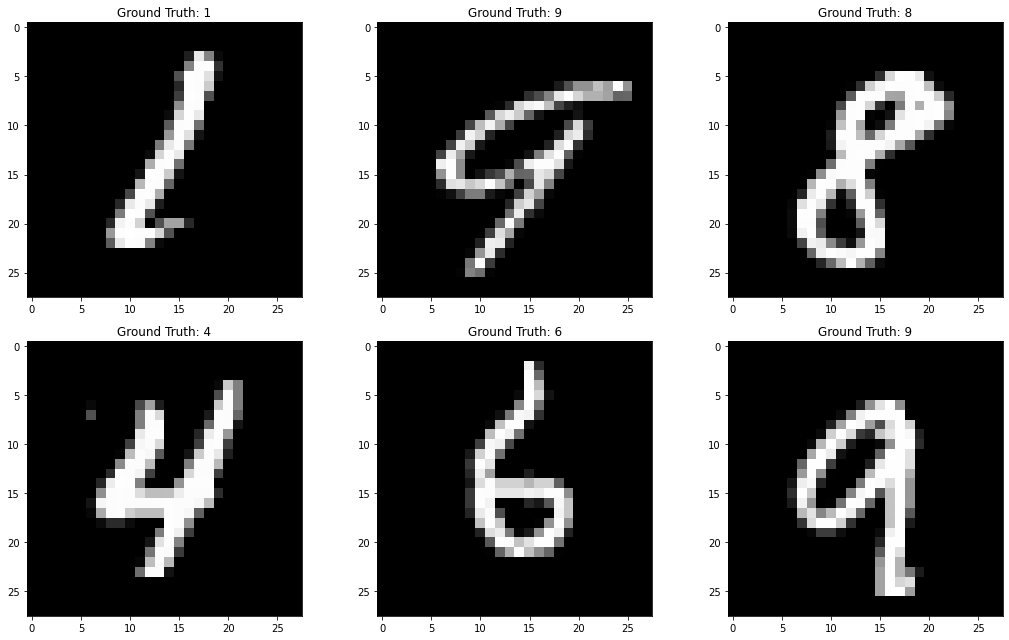

In [3]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

## 2. Model Architecture

In [4]:
class MLPModel(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(MLPModel, self).__init__()
        self.linear = nn.Linear(in_features=in_dim, out_features=hidden_dim, bias=True)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(in_features=hidden_dim, out_features=out_dim, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)        
        return x

## 3. Cost Function Define (Loss Function Define)

In [5]:
cls_loss = nn.CrossEntropyLoss()

## 4. Train & Evaluation

In [6]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# Construct Model
model = MLPModel(in_dim=784, out_dim=10, hidden_dim=200)
model.to(device)
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# Construct Optimizer
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr)

list_epoch = []
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 30
for i in tqdm(range(epoch)):
    # Train
    model.train()
    train_loss = 0
    
    for input_X, true_y in train_loader:
        optimizer.zero_grad()
        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        input_X = input_X.to(device)
        pred_y = model(input_X)
        true_y = true_y.to(device)
        
        loss = cls_loss(pred_y.squeeze(), true_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)
    
    # Validation
    val_loss = 0
    model.eval()
    # Validation 과정에서는 Optimizer를 사용하지 않는다.
    with torch.no_grad(): # Validation 과정에서는 gradient를 활용하지 않기 위함이다.
        for input_X, true_y in val_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            input_X = input_X.to(device)
            pred_y = model(input_X)
            true_y = true_y.to(device)
            
            loss = cls_loss(pred_y.squeeze(), true_y)
            val_loss += loss.item()
        val_loss /= len(val_loader)
        list_val_loss.append(val_loss)
    
    # Evaluation
    correct = 0
    model.eval()
    
    with torch.no_grad():
        for input_X, true_y in test_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            input_X = input_X.to(device)
            pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
            true_y = true_y.to(device)
            correct += pred_y.eq(true_y).sum()
        
        acc = correct.item() / len(test_loader.dataset)
        list_acc.append(acc)
        list_acc_epoch.append(i)
    
    print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%'.format(i, train_loss, val_loss, acc*100))

Number of 159010 parameters


Epoch: 0, Train Loss: 2.077575482771947, Val Loss: 1.7987618079552283, Test Acc: 74.71%
Epoch: 1, Train Loss: 1.4732376749698932, Val Loss: 1.1765506191131396, Test Acc: 81.07%
Epoch: 2, Train Loss: 0.9869886627564064, Val Loss: 0.8391663791277469, Test Acc: 84.19%
Epoch: 3, Train Loss: 0.7476737052966387, Val Loss: 0.6762311764252491, Test Acc: 85.86%
Epoch: 4, Train Loss: 0.6243680104231223, Val Loss: 0.5849923835350916, Test Acc: 86.78%
Epoch: 5, Train Loss: 0.5505953639745712, Val Loss: 0.5279272962839175, Test Acc: 87.77000000000001%
Epoch: 6, Train Loss: 0.5021607242333583, Val Loss: 0.48832176052607024, Test Acc: 88.22%
Epoch: 7, Train Loss: 0.46784694683857453, Val Loss: 0.4595947903700364, Test Acc: 88.72%
Epoch: 8, Train Loss: 0.4417819579442342, Val Loss: 0.4377242903678845, Test Acc: 88.99000000000001%
Epoch: 9, Train Loss: 0.4220376878594741, Val Loss: 0.4209151321496719, Test Acc: 89.12%
Epoch: 10, Train Loss: 0.4061765738022633, Val Loss: 0.40623069191590333, Test Acc: 8

## 5. Report Experiment
학습 과정에서 기록했던 train_loss와 val_loss를 그려봅시다.
Loss가 꾸준히 줄어드는지 확인하고 val_loss가 증가하기 시킨다면 그 이상의 학습은 점점 모델의 성능을 망침을 뜻합니다. 그 옆에는 Epoch에 따라서 MAE metric이 얼마나 감소하는지 확인해봅시다.

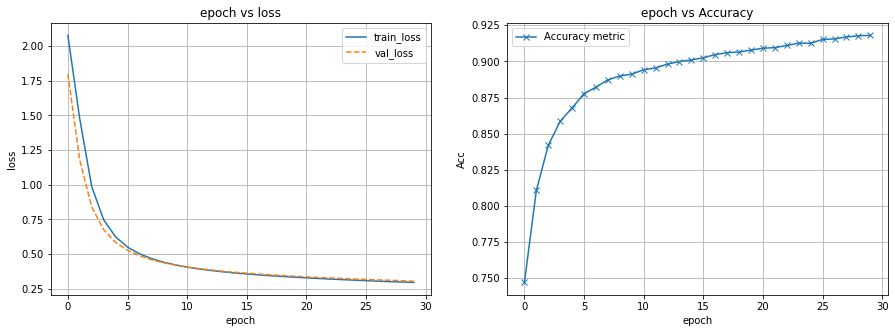

In [7]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()